In [41]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs, ndiffs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import (
    plot_acf,
    month_plot,
    plot_pacf,
    quarter_plot,
)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import shapiro, normaltest, probplot

In [42]:
data = pd.read_csv("../Datasets/Toulouse_Blagnac_traffic.txt", sep=" ")
traffic_ts = pd.DataFrame(
    data={
        "Date": pd.date_range(start="1993-01-01", periods=len(data), freq="M"),
        "Traffic": data["x"],
    }
)
traffic_ts.tail(5)

,Date,Traffic
174,2007-06-30,583.936
175,2007-07-31,557.370
176,2007-08-31,467.139
177,2007-09-30,548.977
178,2007-10-31,526.607


In [43]:
traffic_ts[["Traffic"]].describe()

,Traffic
count,178.000000
mean,400.926545
std,82.258764
min,220.876000
25%,344.016000
50%,412.521000
75%,460.795750
max,583.936000


We have 178 instance :

- 178 months from January 1993 to October 2007
- A mean value of 400


Density of the number of passengers


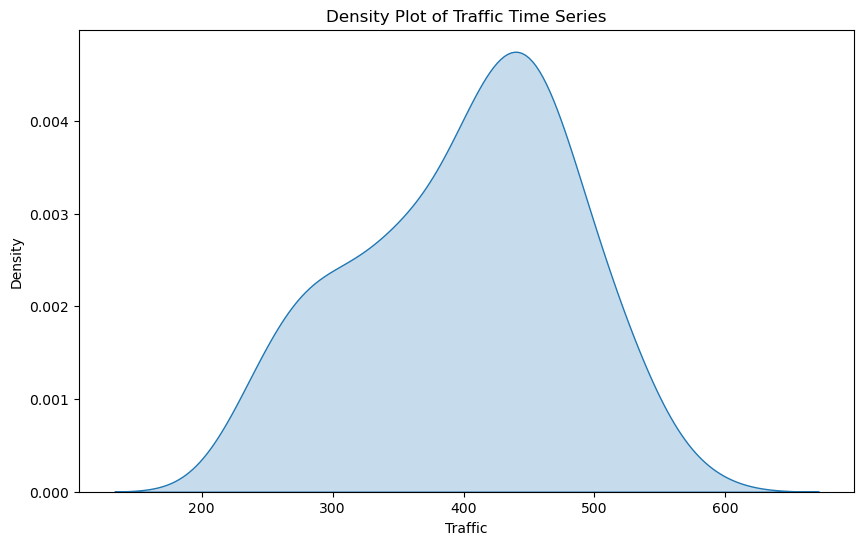

In [44]:
def kde_plot(data):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data, fill=True)
    plt.title("Density Plot of Traffic Time Series")
    plt.xlabel("Traffic")
    plt.ylabel("Density")
    return plt.show()

kde_plot(traffic_ts["Traffic"])

In [45]:
def plot_ts(dataframe, column):
    fig = px.line(dataframe, x="Date", y=column)
    return fig.show()


plot_ts(traffic_ts, "Traffic")

- The minimum value recorded in August 1994 and the maximum value in June 2007


- This graph shows an increasing **trend** (i.e. positive) : we notice that the number of passengers increases over the years with a significant and notable decrease in the number of passengers in the year 2001.


In [46]:
# Create a new columns of month and year
traffic_ts["Month"] = traffic_ts["Date"].dt.strftime("%b")
traffic_ts["Year"] = traffic_ts["Date"].dt.year

In [47]:
# Create the box plot
fig = px.box(
    traffic_ts,
    x="Month",
    y="Traffic",
    points="all",
    title="Monthly Traffic Analysis",
    hover_name="Year",
)
# Group by month and calculate the mean traffic for each month
mean_values = traffic_ts.groupby("Month")["Traffic"].mean()
var_values = traffic_ts.groupby("Month")["Traffic"].var()
# Add mean markers to the plot
fig.add_scatter(
    x=mean_values.index,
    y=mean_values.values,
    mode="markers",
    marker=dict(color="red", size=10, symbol="x"),
    name="Mean value",
)

fig.show()

Traffic for each month throughout the years


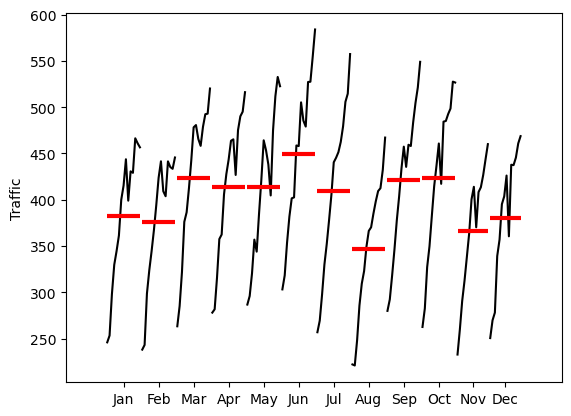

In [48]:
month_plot(traffic_ts[["Traffic", "Date"]].set_index("Date"), ylabel="Traffic")
plt.show()

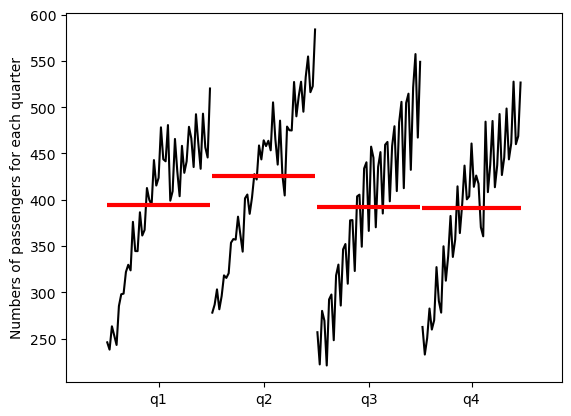

In [49]:
quarter_plot(
    traffic_ts[["Traffic", "Date"]].set_index("Date").to_period("Q"),
    ylabel="Numbers of passengers for each quarter",
)
plt.show()

- We notice that the average number of monthly passengers is not stable over the years and months too, which give more evidence about the seasonality effect and the presence of trend. For example, we can see the number of passengers decreasing in August and increasing in June.


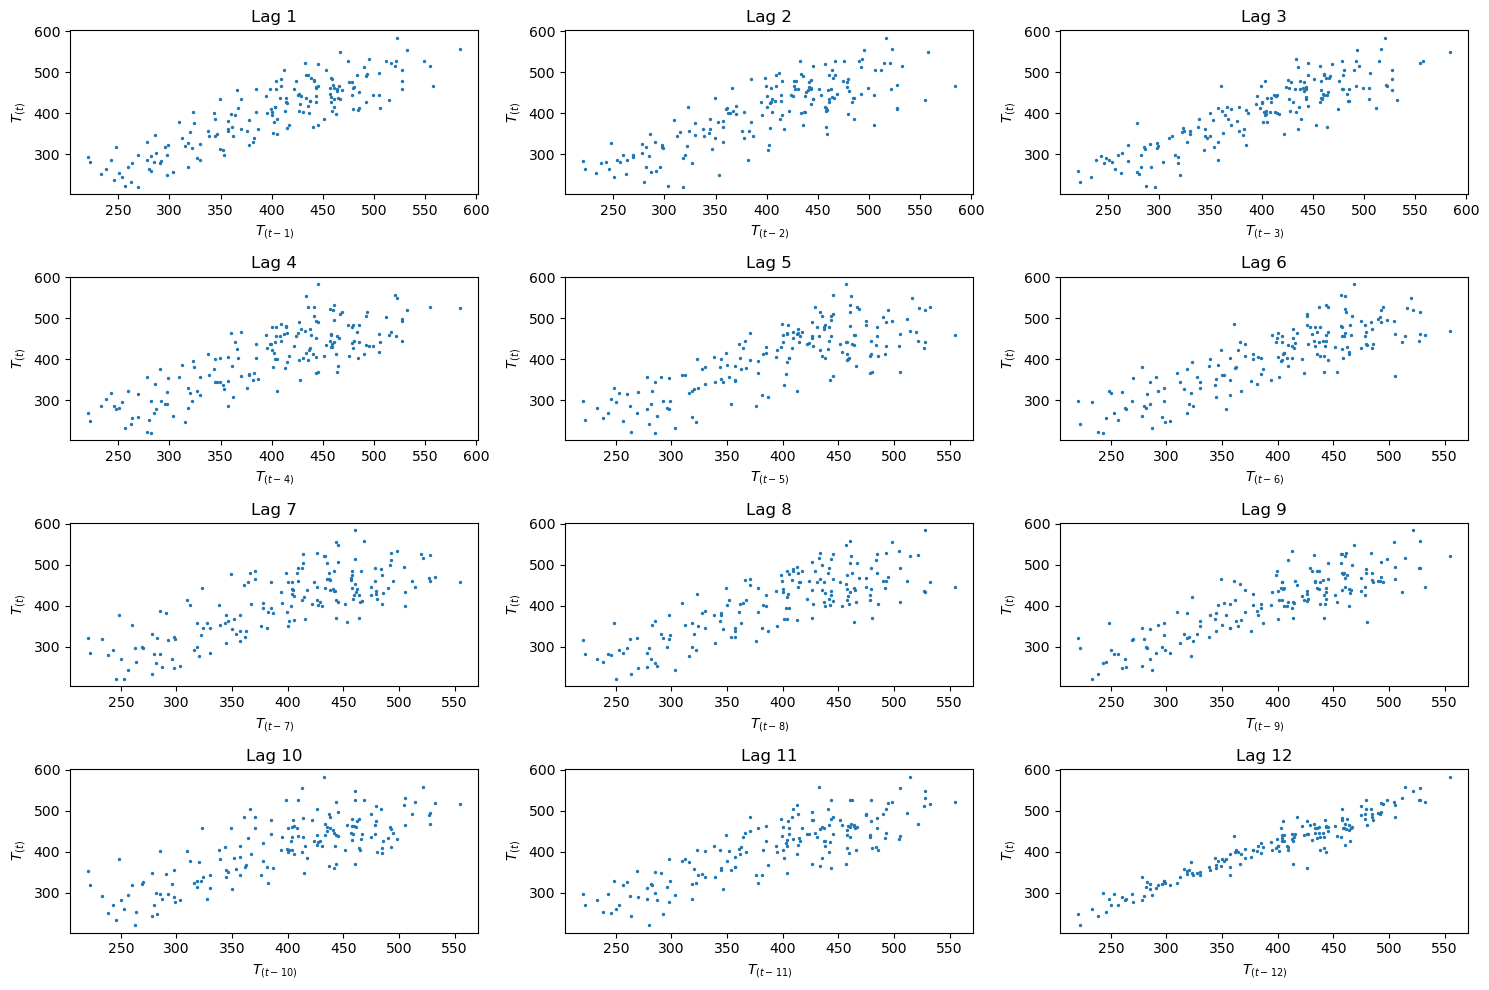

In [50]:
# Number of lags
num_lags = 12

# Create subplots with specified layout
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
axes = axes.flatten()

# Create lag plots
for lag in range(1, num_lags + 1):
    ax = axes[lag - 1]
    ax.scatter(traffic_ts["Traffic"].shift(lag), traffic_ts["Traffic"], s=2)
    ax.set_title(f"Lag {lag}")
    ax.set_xlabel(f"$T_{{(t-{lag})}}$")
    ax.set_ylabel(f"$T_{{(t)}}$")

# Adjust layout
plt.tight_layout()
plt.show()

- From these correlation graphs, we suspect the existence of seasonality and trend because of the linear patterns showed above thus the presence of a presence of a positive autocorrelation especially with in the lag number 12


### Decomposition of the time series :

This decomposition will give us more detail about the overall structure of this time series


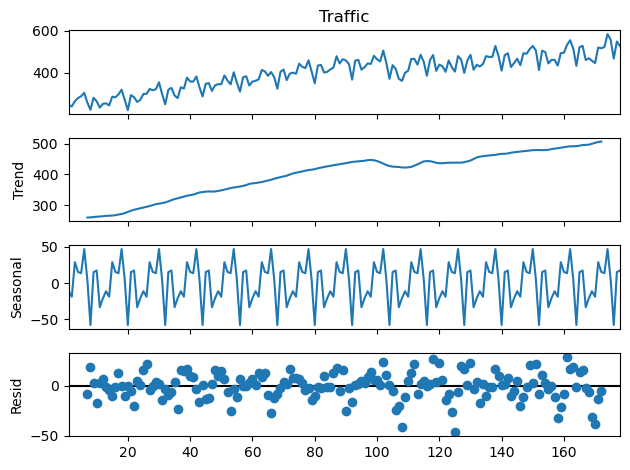

In [51]:
decomp = seasonal_decompose(traffic_ts["Traffic"], model="additive", period=12)
decomp.plot()
plt.show()

- We can see that the trend and seasonality were extracted from the series seems reasonable, the series has indeed a trend and seasonality also the residuals seems to have high variability in the period of 9 to 11 years.


- We will perform ADF test to confirm the existence of trend (non stationnarity of the data)


ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

- Null Hypothesis: The series has a unit root.

- Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.


In [52]:
def adf_test(timeseries, reg):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression=reg, maxlag=None)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


adf_test(traffic_ts["Traffic"], "ct")

Results of Dickey-Fuller Test:
Test Statistic                  -1.891970
p-value                          0.658820
#Lags Used                      13.000000
Number of Observations Used    164.000000
Critical Value (1%)             -4.015059
Critical Value (5%)             -3.437607
Critical Value (10%)            -3.142967
dtype: float64


- the $p_{{value}} = 0.65 > 0.05$ thus we can't reject the null hypothesis : the series is not stationnary and the trend exist


- The objective of this next part is to transform the series into a stationary process through differentiation, which we will model.
- We are studying the series between January 1993 and October 2004. We will start by splitting the series into two subsets: one for modeling (training series) and the other for model validation (validation series).


In [53]:
traffic_train = traffic_ts[["Date", "Traffic"]].iloc[: round(len(traffic_ts) * 0.80)]
traffic_test = traffic_ts[["Date", "Traffic"]].iloc[round(len(traffic_ts) * 0.80) :]

In [54]:
plot_ts(traffic_train, "Traffic")

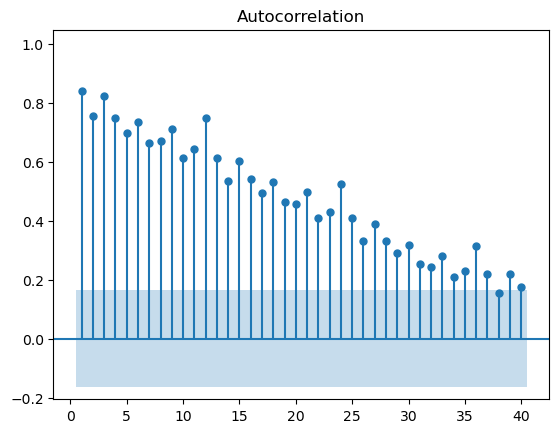

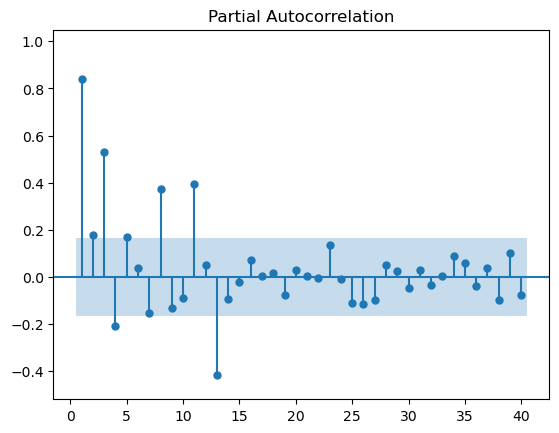

In [55]:
plot_acf(
    traffic_train["Traffic"],
    alpha=0.05,
    lags=40,
    bartlett_confint=False,
    zero=False,
    auto_ylims=True,
)
plot_pacf(
    traffic_train["Traffic"],
    alpha=0.05,
    method="ywmle",
    lags=40,
    zero=False,
    auto_ylims=True,
)
plt.show()

From the ACF and PACF, we can notice the behavior of a series that has a trend : a lot of values are positively correlated with their past values which explains the positive trend


To eliminate the trend the we need to differntiate the series, to find the number of $d$ : how many times we will differntiate our series, we can perform a test of stationarity for different levels of $d$ to estimate the number of differences required to make a given time series stationary.


In [56]:
ndiffs(traffic_train["Traffic"], test="adf", max_d=3)

1

In [57]:
# Differentiate the time series
traffic_train_dif = (
    traffic_train.set_index("Date", drop=True).diff(periods=1).dropna(axis=0)
)

In [58]:
plot_ts(traffic_train_dif.reset_index(), "Traffic")

We can notice that the series is no longer going upward by time, this could be to detrending the series by differntiating


In [59]:
adf_test(traffic_train_dif["Traffic"], reg="ct")

Results of Dickey-Fuller Test:
Test Statistic                  -4.641784
p-value                          0.000877
#Lags Used                      14.000000
Number of Observations Used    126.000000
Critical Value (1%)             -4.032478
Critical Value (5%)             -3.445926
Critical Value (10%)            -3.147829
dtype: float64


- We can notice that after differnciating the series the series is stationnary according to the ADF test where we have $p_{{value}} = 0.01 < 0.05$ : we reject the enull hypothesis that the data has a unit root (i.e is non-stationnary)


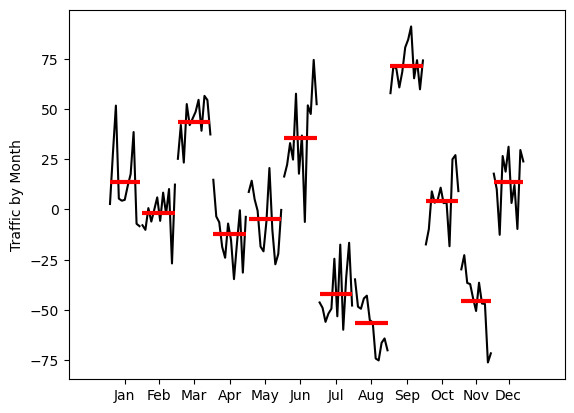

In [60]:
month_plot(traffic_train_dif, ylabel="Traffic by Month")
plt.show()

[]

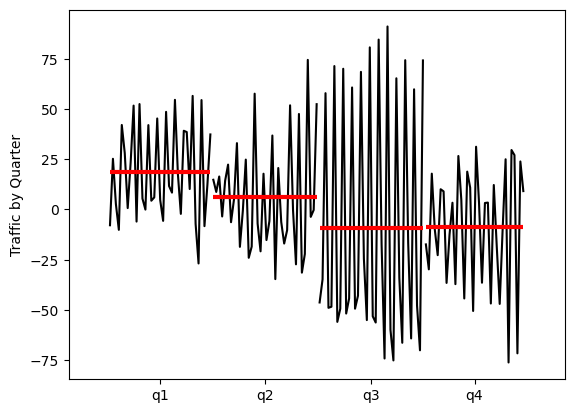

In [61]:
quarter_plot(traffic_train_dif.to_period("Q"), ylabel="Traffic by Quarter")
plt.plot()

[]

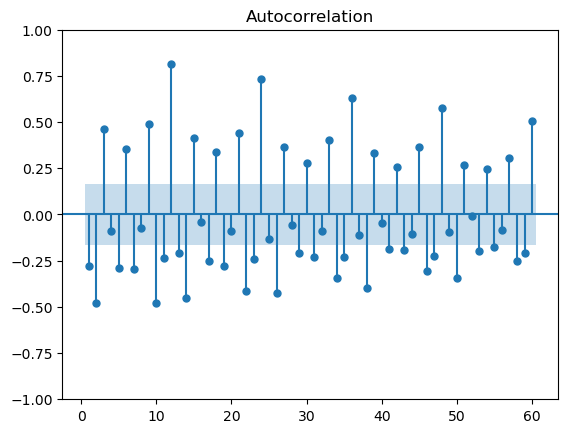

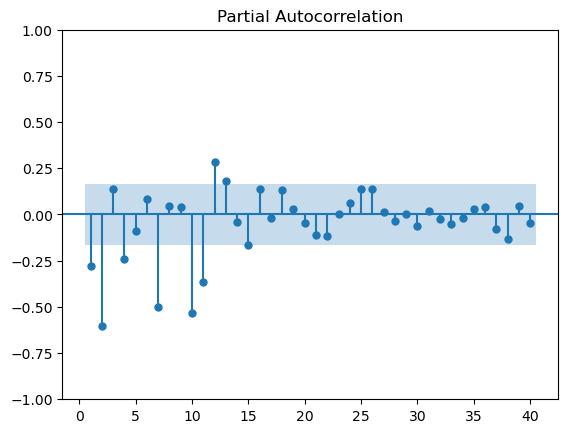

In [62]:
plot_acf(
    traffic_train_dif,
    lags=60,
    missing="drop",
    zero=False,
    alpha=0.05,
    bartlett_confint=False,
)
plot_pacf(traffic_train_dif, lags=40, zero=False)

plt.plot()

From the PACF and ACF we can notice that the series might have has a seasonal pattern it could be yearly because of the spkies in the ACF values in the lag number 12

Apply OCSB test statistically if the series has a seasonal pattern and determine D by applying OCSB test :


In [63]:
nsdiffs(traffic_train_dif, max_D=3, m=12, test="ocsb")

1

We will differentiate now the series by twelve months and drop the NA values to create a new non-seasonal dataframe


In [64]:
traffic_train_sdif = traffic_train_dif.diff(12).dropna(axis=0)

- We will aplly the ocsb test again to confirm that our series no longer has seasonality


In [65]:
nsdiffs(traffic_train_sdif, max_D=2, m=12, test="ocsb")

0

- The data no longer has seasonality and it can also be verified visually


In [66]:
plot_ts(traffic_train_sdif.reset_index(), "Traffic")

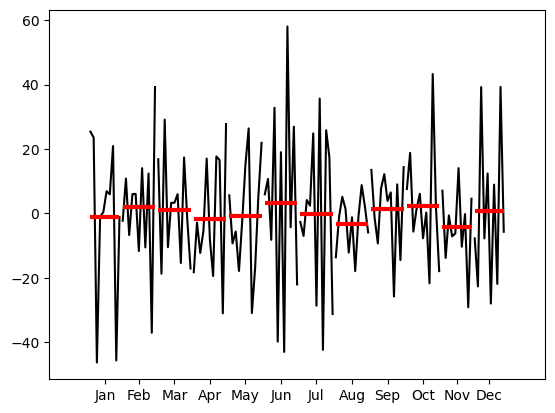

In [67]:
month_plot(traffic_train_sdif)
plt.show()

[]

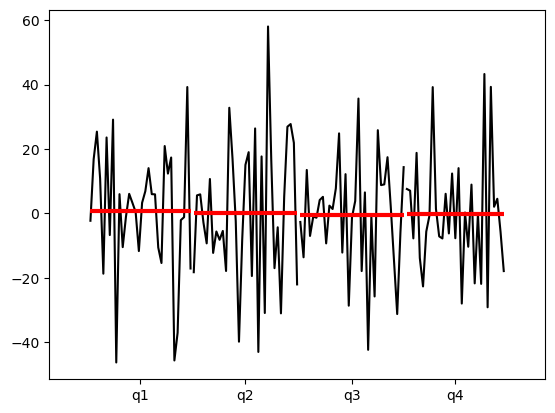

In [68]:
quarter_plot(traffic_train_sdif.to_period("Q"))
plt.plot()

- The graphs above show that our data doesn't have any seasonal pattern


- No we will move on to estimating our $SARIMA$ model


[]

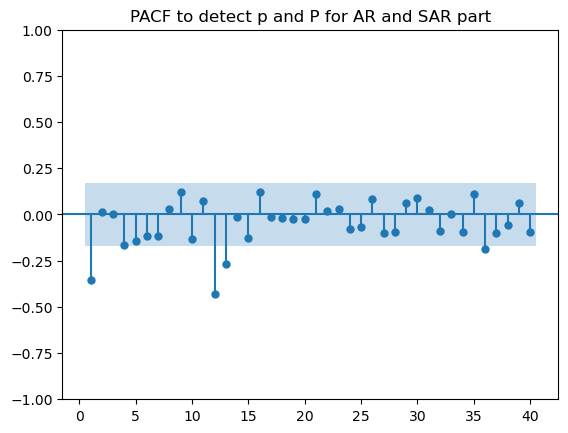

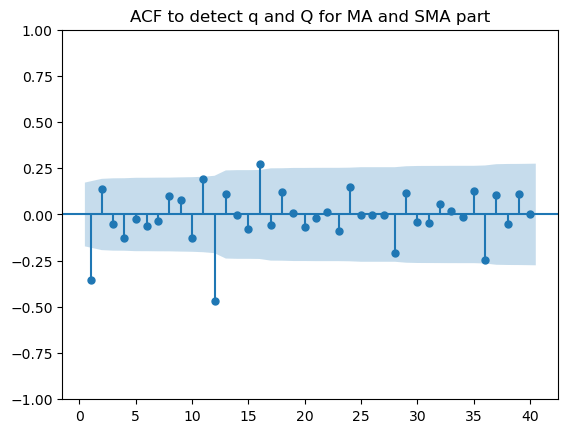

In [69]:
plot_pacf(
    traffic_train_sdif,
    zero=False,
    title="PACF to detect p and P for AR and SAR part",
    lags=40,
)
plot_acf(
    traffic_train_sdif,
    missing="drop",
    bartlett_confint=True,
    zero=False,
    title="ACF to detect q and Q for MA and SMA part",
    lags=40,
)
plt.plot()

For the AR and SAR part we look at the PACF plot:

- The **non seasonal behavior** from the first few lags we can see that have one clear spike above the $0.05$ threshold so $p_{max}= 1$.
- The **seasonal behavior** can be detected it by looking at what's around the lags that are multpile of 12, here we have one clear spike above the threshold $0.05$ at the lag 12 $P_{max} = 2$


We do the same thing to detect the parameters of the MA and SMA part where we look at the ACF plot.

- here we can notice that $q_{max} = 1$ and $Q_{max} = 1$


Also we have $d=1$ for differciating one time to eliminate the trend and $D = 1$ with a period of $s = 12$ for differentiating


So we have to choose a model that has :
$$SARIMA(p_{max}=1,d=1, q_{max}=1)(Q_{max}=1, D=1, Q_{max}=1)_{12}$$


The equation for the model $SARIMA(p=1,d=1, q=1)(Q=1, D=1, Q=1)_{{(12)}}$ is the following :


$$
(1 - L^{12})Y_t =\frac{(1 + \theta_1 L)(1 + \Theta_1 L^{12})\varepsilon_t}{(1 - \phi_1 L)(1 - \Phi_1 L^{12})}
$$


- $\phi $ is the non-seasonal autoregressive coefficient.
- $\Phi $ is the seasonal autoregressive coefficient.
- $\theta $ is the non-seasonal moving average coefficient.
- $\Theta $ is the seasonal moving average coefficient.
- $Y_t $ is the time series at time $t$.
- $L^{12} $ is the seasonal lag operator.


- We will estimate this model and then use auto.arima to brute force all the models and select automatically the ebest one that has the lowest AIC


In [70]:
arima = pm.ARIMA(order=[1, 1, 0], seasonal_order=[1, 1, 1, 12], with_intercept=False)
result = arima.fit(traffic_train["Traffic"])
result.summary()

/home/zack/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/zack/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -533.027
Date:                              Thu, 11 Jul 2024   AIC                           1074.055
Time:                                      20:50:50   BIC                           1085.494
Sample:                                           0   HQIC                          1078.703
                                              - 142                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3666      0.070     -5.234      0.000      -0.504      -0.229
ar.S.L12      -0.0778      0.168     -0.463      0.643      -0.407       0.251
ma.S.L12      -0.6120      0.158     -3.873      0.000      -0.922      -0.302
sigma2       215.3295     30.735      7.006      0.000     155.090     275.569
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.89   Prob(JB):                         0.80
Heteroskedasticity (H):               1.91   Skew:                            -0.03
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We can notice that the first three features aren't statistically significant


the root mean square error of this model on the train data is equalt to : 28.21, which is not bad


In [71]:
mean_squared_error(traffic_train["Traffic"], result.fittedvalues(), squared=False)

28.22334052790624

Now we will use the the auto_arima function to brute force and chose the best model according to aic criterion given that $d=1$ and $D=1$


In [72]:
auto_arima = pm.arima.auto_arima(
    traffic_train["Traffic"],
    start_p=0,
    d=1,
    start_q=0,
    start_P=0,
    start_Q=0,
    D=1,
    max_p=1,
    max_q=1,
    max_P=2,
    max_Q=1,
    seasonal=True,
    m=12,
    test="kpss",
    information_criterion="aic",
    with_intercept=True,
)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -533.168
Date:                              Thu, 11 Jul 2024   AIC                           1072.337
Time:                                      20:50:54   BIC                           1080.916
Sample:                                           0   HQIC                          1075.823
                                              - 142                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3623      0.070     -5.190      0.000      -0.499      -0.225
ma.S.L12      -0.6645      0.082     -8.136      0.000      -0.825      -0.504
sigma2       215.5264     30.853      6.986      0.000     155.056     275.996
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.87   Prob(JB):                         0.80
Heteroskedasticity (H):               1.94   Skew:                            -0.03
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model by the AIC selection criterion is $SARIMA(p=1,d=1, q=0)(Q=0, D=1, Q=1)_{{(12)}}$


- From the T-statistics all the features are statistically significant
- This model minimizes the AIC criterion


We will try to graph fitted values and actual values in the same graph


In [73]:

# Create a dataframe for the fitted values
fitted_values = pd.DataFrame(
    data={"Date": traffic_train["Date"], "Traffic_fitt": auto_arima.fittedvalues()}
)
# merge fitted values and acutual values in a dataframe
fit_actual_values = pd.merge(
    traffic_ts[["Date", "Traffic"]], fitted_values.iloc[1:], on="Date", how="outer"
)

In [74]:
# Graph fit and actual values in the same graph
fig2 = px.line(fit_actual_values, x="Date", y=fit_actual_values.columns)
fig2.show()

Visually the model did pretty good capturing the information of numbers of passengers throughtout the years.


- The RMSE of the train data is pretty good too, the model is having a good fit


In [75]:
mean_squared_error(traffic_train["Traffic"], auto_arima.fittedvalues(), squared=False)

28.233252416458292

### Residual analysis for model validation

- To validate the assumptions of this SARIMA model we need to analyze the residuals:
  - they have to be iid and follows a normal distribution


### Normality of the residuals


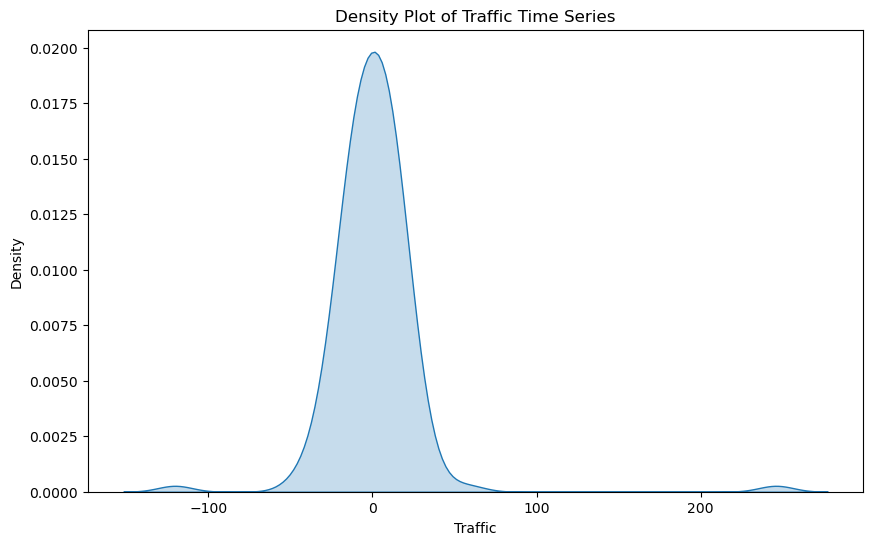

In [76]:
# kernal density estimation of the residuals
kde_plot(auto_arima.resid())

The shape of this distribution is morelikely follows a normal distribution


Shapiro wilk test : The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected


In [77]:
shapiro(auto_arima.resid())

ShapiroResult(statistic=0.6463264226913452, pvalue=5.336744649937765e-17)

Conclusion : We reject the null hypothesis the data didn't come form a normal distribution


In [78]:
auto_arima.resid().sort_values()

13    -120.219472
7      -46.282258
122    -41.012368
8      -34.795739
53     -30.182903
          ...    
118     28.186963
126     34.234245
127     38.050235
9       57.856252
1      245.872000
Length: 142, dtype: float64

Ps : this could be because of the values in the tail of the distribution (outliers), let's redo the test by removing the fat tails the values with indexes 12 and 1:


In [81]:
clean_res = auto_arima.resid().drop([1, 12])
clean_res

1      245.872000
2       -7.842077
3       25.206217
4       14.769719
5        8.699846
          ...    
138      8.640734
139    -13.943281
140    -10.930413
141      2.192919
142     -2.377436
Length: 141, dtype: float64

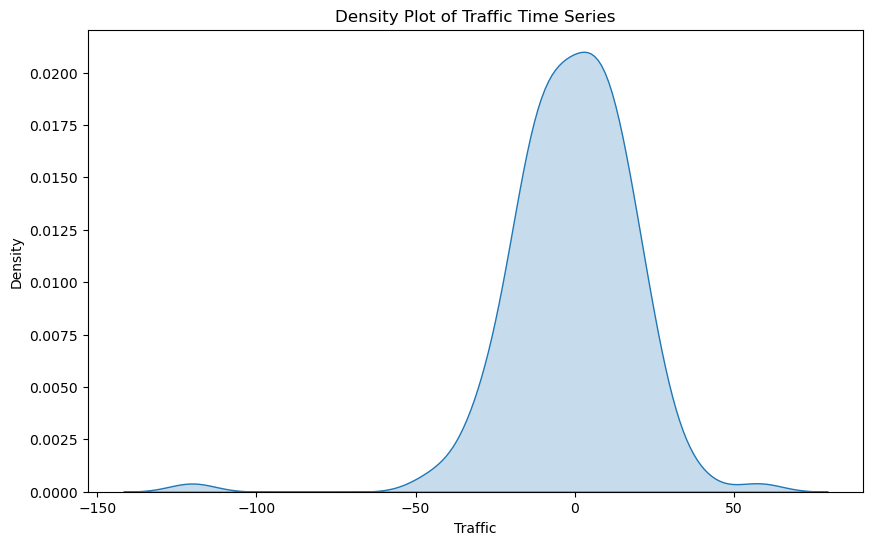

In [ ]:
kde_plot(clean_res)

- Well now the data looks pretty normal, we have more evidence that the data follows a normal distribution: we will stick to that for the upcoming analysis


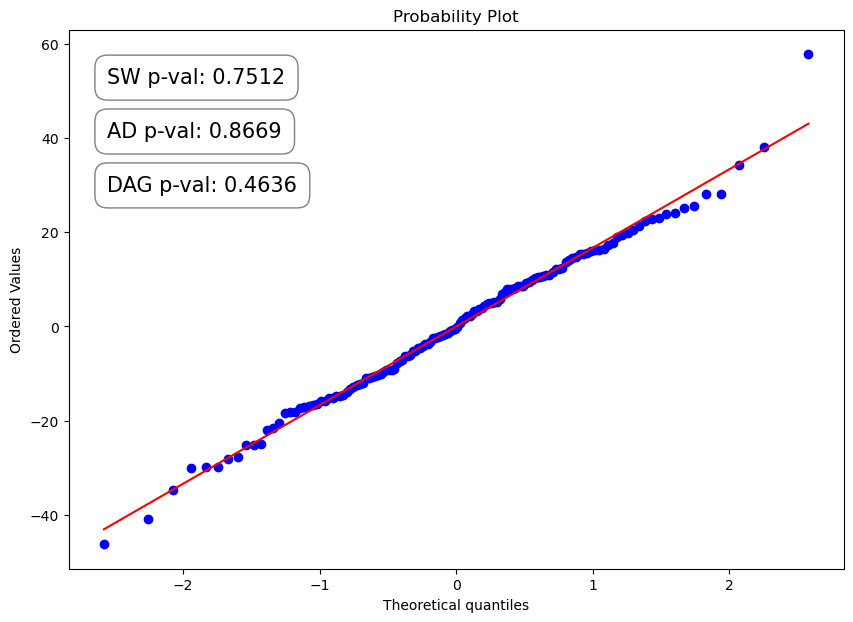

In [ ]:
sw_result = shapiro(clean_res)
ad_result = normal_ad(np.array(clean_res), axis=0)
dag_result = normaltest(clean_res, axis=0, nan_policy='propagate')

plt.figure(figsize=(10,7))
res = probplot(clean_res, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
plt.show()

### Autocorrelation of the residuals


- We will start by graphing the ACF and PACF of our residuals


[]

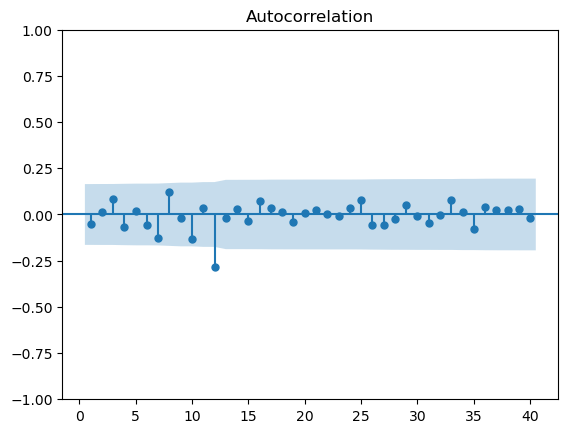

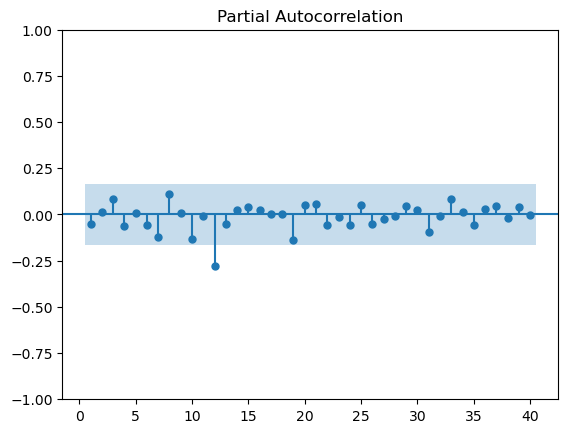

In [ ]:
plot_acf(auto_arima.resid(), lags=40, zero=False)
plot_pacf(auto_arima.resid(), lags=40, zero=False)
plt.plot()

In [ ]:
sm.stats.acorr_ljungbox(auto_arima.resid(), boxpierce=True, lags=15, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.393560,0.530434,0.385361,0.534748
2,0.428799,0.807026,0.419621,0.810738
3,1.472631,0.688601,1.427209,0.699169
4,2.174770,0.703651,2.100092,0.717355
5,2.222645,0.817558,2.145640,0.828648
6,2.668270,0.849181,2.566508,0.860951
7,5.069894,0.651434,4.818030,0.682159
8,7.415442,0.492543,7.000693,0.536558
9,7.468447,0.588468,7.049649,0.631950
10,10.204768,0.422716,9.557943,0.480093


- From the Box pierce test we can't confirm that the residuals aren't correlated


Now we will move on to predictions


In [ ]:
# get the prediction with their confidence intervalle with a confidence level of 95%
predictions = auto_arima.predict(
    n_periods=len(traffic_test), return_conf_int=True, alpha=0.05
)
# Create a data frame for all predicted values
traffic_predict = pd.DataFrame(
    data={
        "Date_": pd.date_range(
            start=traffic_test["Date"].iloc[0],
            periods=len(traffic_test),
            freq="M",
        ),
        "Traffic_predict": predictions[0],
        "lower_int": [(predictions[1][i][0]) for i in range(len(predictions[1]))],
        "upper_int": [(predictions[1][i][1]) for i in range(len(predictions[1]))],
    }
)

In [ ]:
traffic_predict.head()

,Date_,Traffic_predict,lower_int,upper_int
142,2004-11-30,433.660127,404.885255,462.434998
143,2004-12-31,450.296031,416.167510,484.424551
144,2005-01-31,455.854256,415.180386,496.528126
145,2005-02-28,455.512013,409.846995,501.177031
146,2005-03-31,501.668612,451.299555,552.037669


RMSFE (root mean squared forecasting error) on the test set is equal to 18 which is really good


In [ ]:
mean_squared_error(
    traffic_test["Traffic"], (traffic_predict["Traffic_predict"]), squared=False
)

18.52551098182396

The MAPE (mean absolute percentage error) is equal to 2.9% : This means that, on average, the forecasting model's predictions are off by about 2.9% from the actual values


In [ ]:
mean_absolute_percentage_error(
    traffic_test["Traffic"], (traffic_predict["Traffic_predict"])
)

0.029328893248244812

Create a Dataframe that contains Actual values, fitted values and predicted values with their confidence intervall


In [ ]:
fit_actual_values_pred = pd.concat(
    [fit_actual_values, traffic_predict], axis=1, join="outer"
).drop("Date_", axis=1)

In [ ]:
fit_actual_values_pred

,Date,Traffic,Traffic_fitt,Traffic_predict,lower_int,upper_int
0,1993-01-31,245.872,NaN,NaN,NaN,NaN
1,1993-02-28,238.014,245.856077,NaN,NaN,NaN
2,1993-03-31,263.227,238.020783,NaN,NaN,NaN
3,1993-04-30,277.991,263.221281,NaN,NaN,NaN
4,1993-05-31,286.691,277.991154,NaN,NaN,NaN
...,...,...,...,...,...,...
173,2007-06-30,583.936,NaN,555.710059,396.241245,715.178874
174,2007-07-31,557.370,NaN,517.993702,354.665092,681.322311
175,2007-08-31,467.139,NaN,451.521101,284.422049,618.620153
176,2007-09-30,548.977,NaN,522.904979,352.118625,693.691333


Now we will plot the forecasts with their respective prediction interval


In [ ]:
fig3 = px.line(fit_actual_values_pred, x="Date", y=fit_actual_values_pred.columns)
fig3.show()

The forecasts obtained by the model are really good, the model captured all the seasonality and trend in the data giving near to reality results on the unseen data set

### Conclusion :
- In this notebook we learned how to estimate and choose the right SARIMA model when we have a data with seasonality and trend
- Choosing the right model can be tricky so using the auto_arima with the right parameters helps a lot to indetify the best model quickly
- When analyzing the residuals we need to check the nature of the residuals distribution and try to understand it just like we analyze the normal time series in our case we found outliers in our residuals due to the differentiating the series
A better approach to this data series could also be using dynamic forecasting where we try to model the residuals too to capture more information about the data